In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, JLD

### Require Function

In [2]:
function get_y_revised(y, N)
    # Add additional two more points on the tail
    y_revised = zeros(N+2)
    y_revised[1:N] = y[:]
    y_revised[N+1] = y[end]
    y_revised[end] = y[end]
    return y_revised
end

function get_x_revised(x, N, e_norm)
    # Add additional two more points on the tail
    x_revised = zeros(N+2)
    x_revised[1:N] = x[:]
    x_revised[N+1] = x[end] + e_norm
    x_revised[end] = x[end] + 2 * e_norm
    return x_revised
end

function first_derivative(x, y, N, e_norm)
    y_revised = get_y_revised(y, N)
    x_revised = get_x_revised(x, N, e_norm)
    first_derivative = diff(y_revised) ./ diff(x_revised)
    return first_derivative # return array of y'(x)
end


function second_derivative(x, y, N, e_norm)
    first_deriv = first_derivative(x, y, N, e_norm)
    x_revised = get_x_revised(x, N, e_norm)
    second_derivative = diff(first_deriv) ./ diff(x_revised[1:N+1])
    return second_derivative # return array of y''(x)
end

second_derivative (generic function with 1 method)

### Part 1: Get collocation points and integration kernel for whole domain

In [3]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [4]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1

### Part 3: Get eigenvalues and eigenvectors

In [5]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv);

### Part 4: Get second derivative and plots

In [29]:
# Select eigenvector from eigenvector matrix
eigv_id = 1
psi_1 = Qx[:,eigv_id];
psi_second_deriv = second_derivative(xref[:,1], psi_1, N, e_norm);

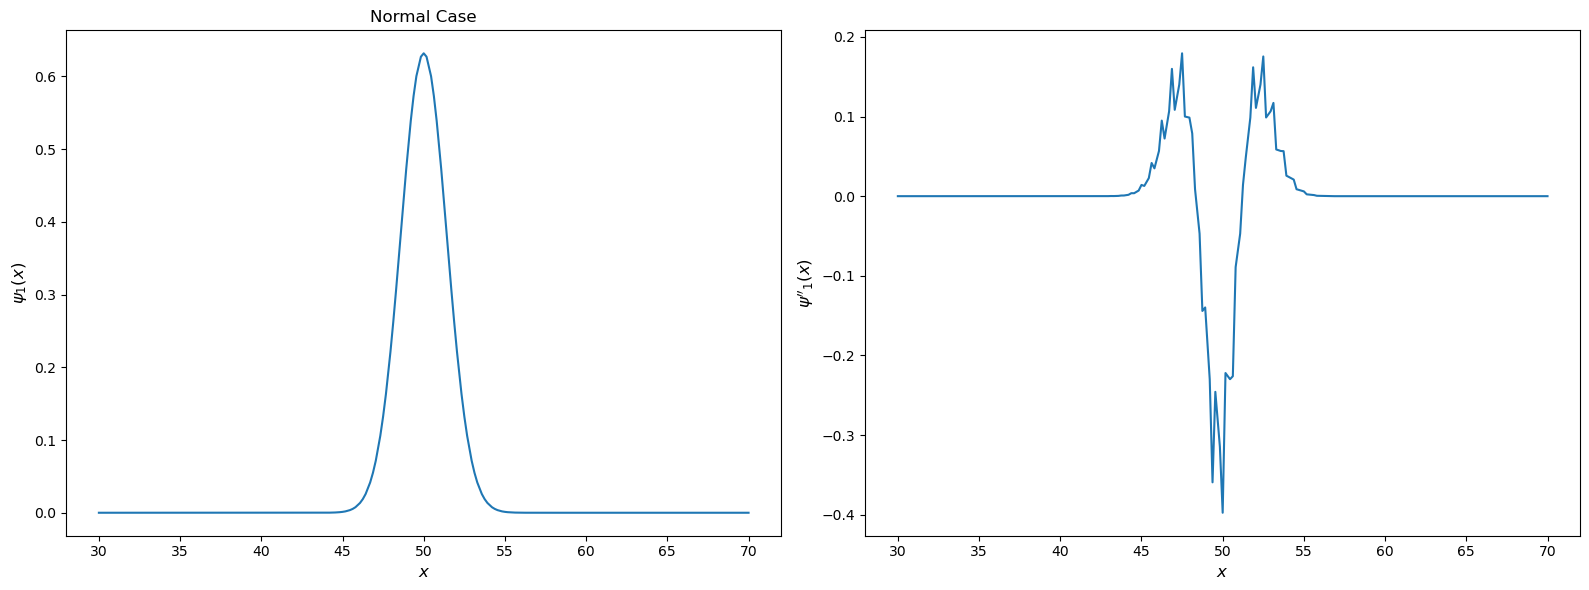

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

title = "Normal Case" # Ad hoc

ax = axes[1]
ax.plot(xref, psi_1)
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.set_title(title)
plt.tight_layout()

ax = axes[2]
ax.plot(xref, psi_second_deriv)
ax.set_ylabel("\$ \\psi''_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)

plt.tight_layout()
#plt.savefig("normal_case.png", dpi=100)
plt.show()

### Part 5: Small modification

In [31]:
# Select eigenvector from eigenvector matrix
eigv_id = 1
psi_1 = Qx[:,eigv_id];
psi_1[97] = 0.61
psi_second_deriv = second_derivative(xref[:,1], psi_1, N, e_norm);

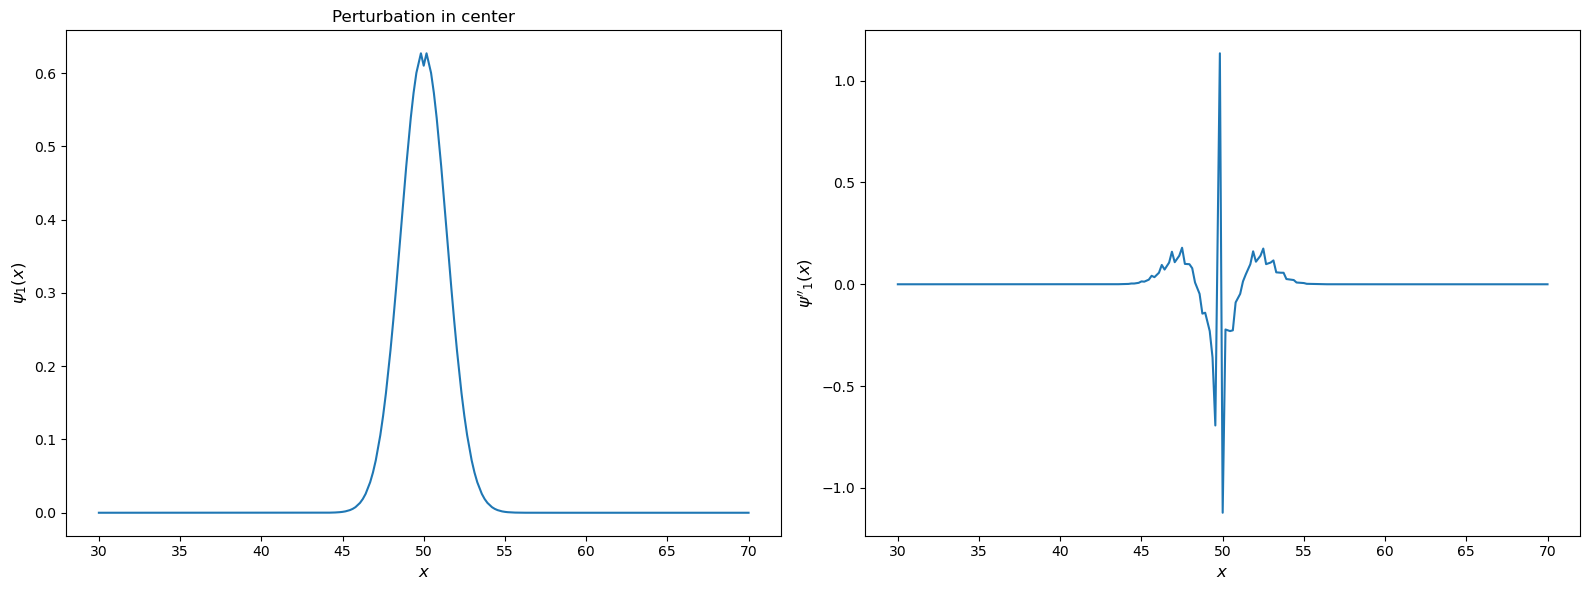

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

title = "Perturbation in center" # Ad hoc

ax = axes[1]
ax.plot(xref, psi_1)
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.set_title(title)
plt.tight_layout()

ax = axes[2]
ax.plot(xref, psi_second_deriv)
ax.set_ylabel("\$ \\psi''_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)

plt.tight_layout()
#plt.savefig("small_perturbation_1.png", dpi=100)
plt.show()

### Part 6: Small modification

In [33]:
# Select eigenvector from eigenvector matrix
eigv_id = 1
sele_x_idx = 94
psi_1 = Qx[:,eigv_id];
psi_1[sele_x_idx] = 0.55
psi_second_deriv = second_derivative(xref[:,1], psi_1, N, e_norm);

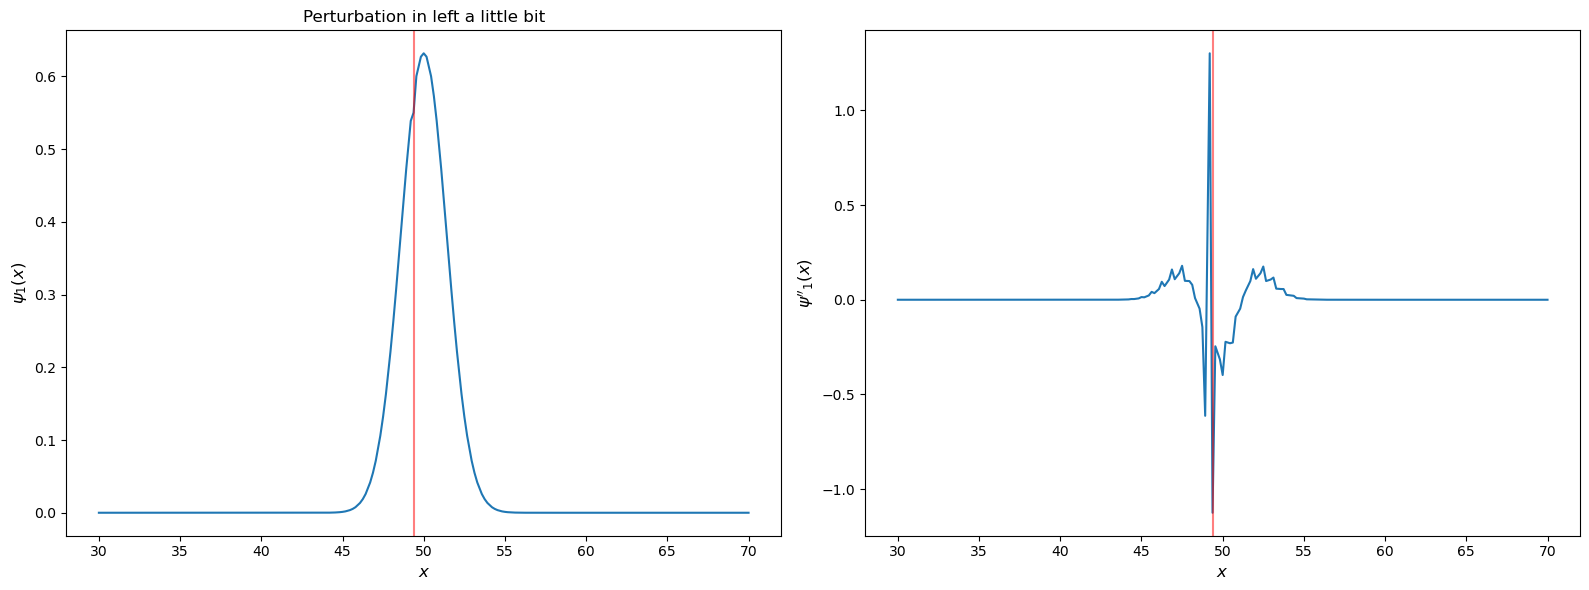

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

title = "Perturbation in left a little bit" # Ad hoc

ax = axes[1]
ax.plot(xref, psi_1)
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.set_title(title)
ax.axvline(xref[sele_x_idx], color="red", alpha=0.5)
plt.tight_layout()

ax = axes[2]
ax.plot(xref, psi_second_deriv)
ax.set_ylabel("\$ \\psi''_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.axvline(xref[sele_x_idx], color="red", alpha=0.5)

plt.tight_layout()
#plt.savefig("small_perturbation_2.png", dpi=100)
plt.show()

### Part 7: xavg=35, EM-100

In [35]:
xavg_guess = 35.

# Read
f_in = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d.jld" xavg_guess xavg # Ad hoc
p_container = load(f_in, "p_container")
println(@sprintf "Load p_container from %s" f_in)

Load p_container from /home/yizaochen/codes/julia/EM_data/p0_xavg_35_pref_xavg_50.jld


In [36]:
iter_id_sele = 100 # ad hoc

p_em = p_container[iter_id_sele, :]
Lambdas_EM, Qx_EM, rho_EM = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_em, D, Nv);

In [42]:
# Select eigenvector from eigenvector matrix
eigv_id = 1
sele_x_idx = 97
psi_1 = Qx_EM[:,eigv_id];
psi_second_deriv = second_derivative(xref[:,1], psi_1, N, e_norm);

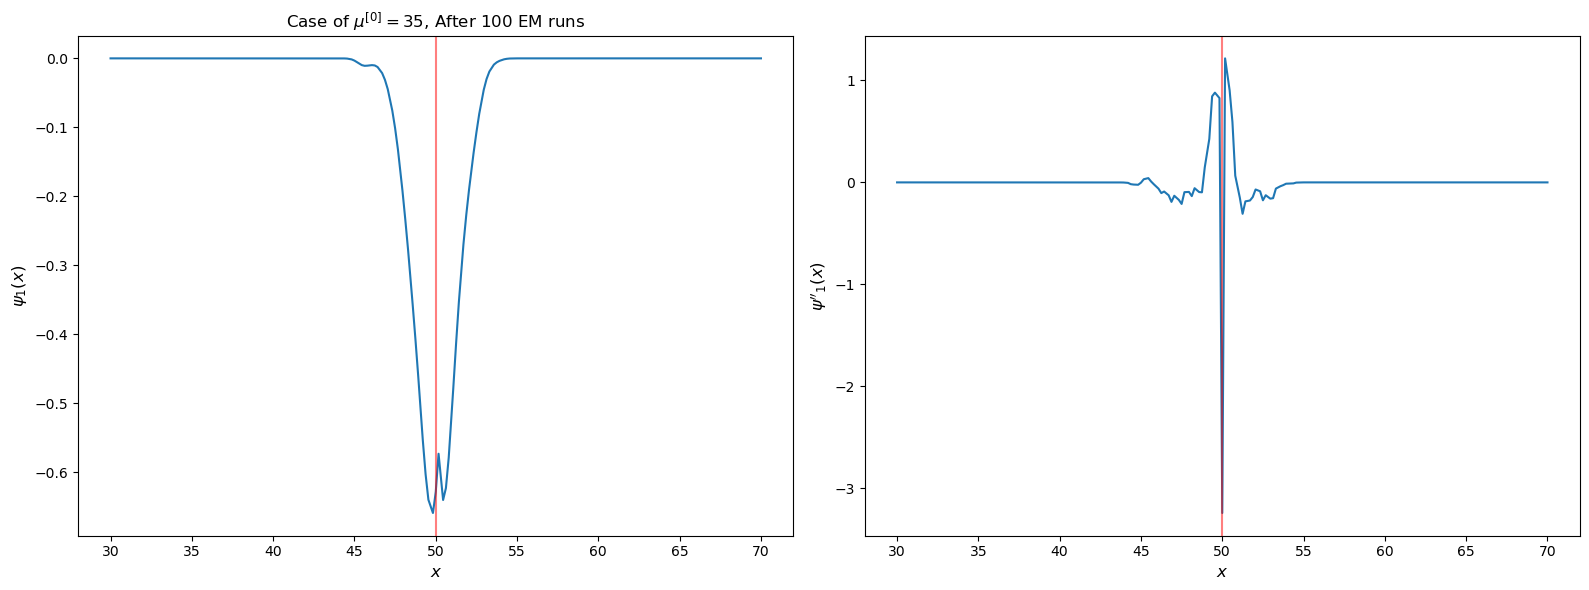

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

title = "Case of \$\\mu^{[0]}=35\$, After 100 EM runs" # Ad hoc

ax = axes[1]
ax.plot(xref, psi_1)
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.set_title(title)
ax.axvline(xref[sele_x_idx], color="red", alpha=0.5)
plt.tight_layout()

ax = axes[2]
ax.plot(xref, psi_second_deriv)
ax.set_ylabel("\$ \\psi''_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)
ax.axvline(xref[sele_x_idx], color="red", alpha=0.5)

plt.tight_layout()
#plt.savefig("mu0_35_100_EM.png", dpi=100)
plt.show()

### Part 8: Find maximum and location in x-position

In [57]:
function get_loc_number_of_abrupt(y::Array{Float64,1})
    y = abs.(y)
    idx_larger_than_1 = findall(x -> x>=1, y)
    return length(idx_array), idx_larger_than_1
end

get_loc_number_of_abrupt (generic function with 1 method)

In [58]:
n_larger_than_1, idx_larger_than_1 = get_loc_number_of_abrupt(psi_second_deriv)

(2, [97, 98])

### Additional Part 1: Test drawing(Modify distribution by hand)

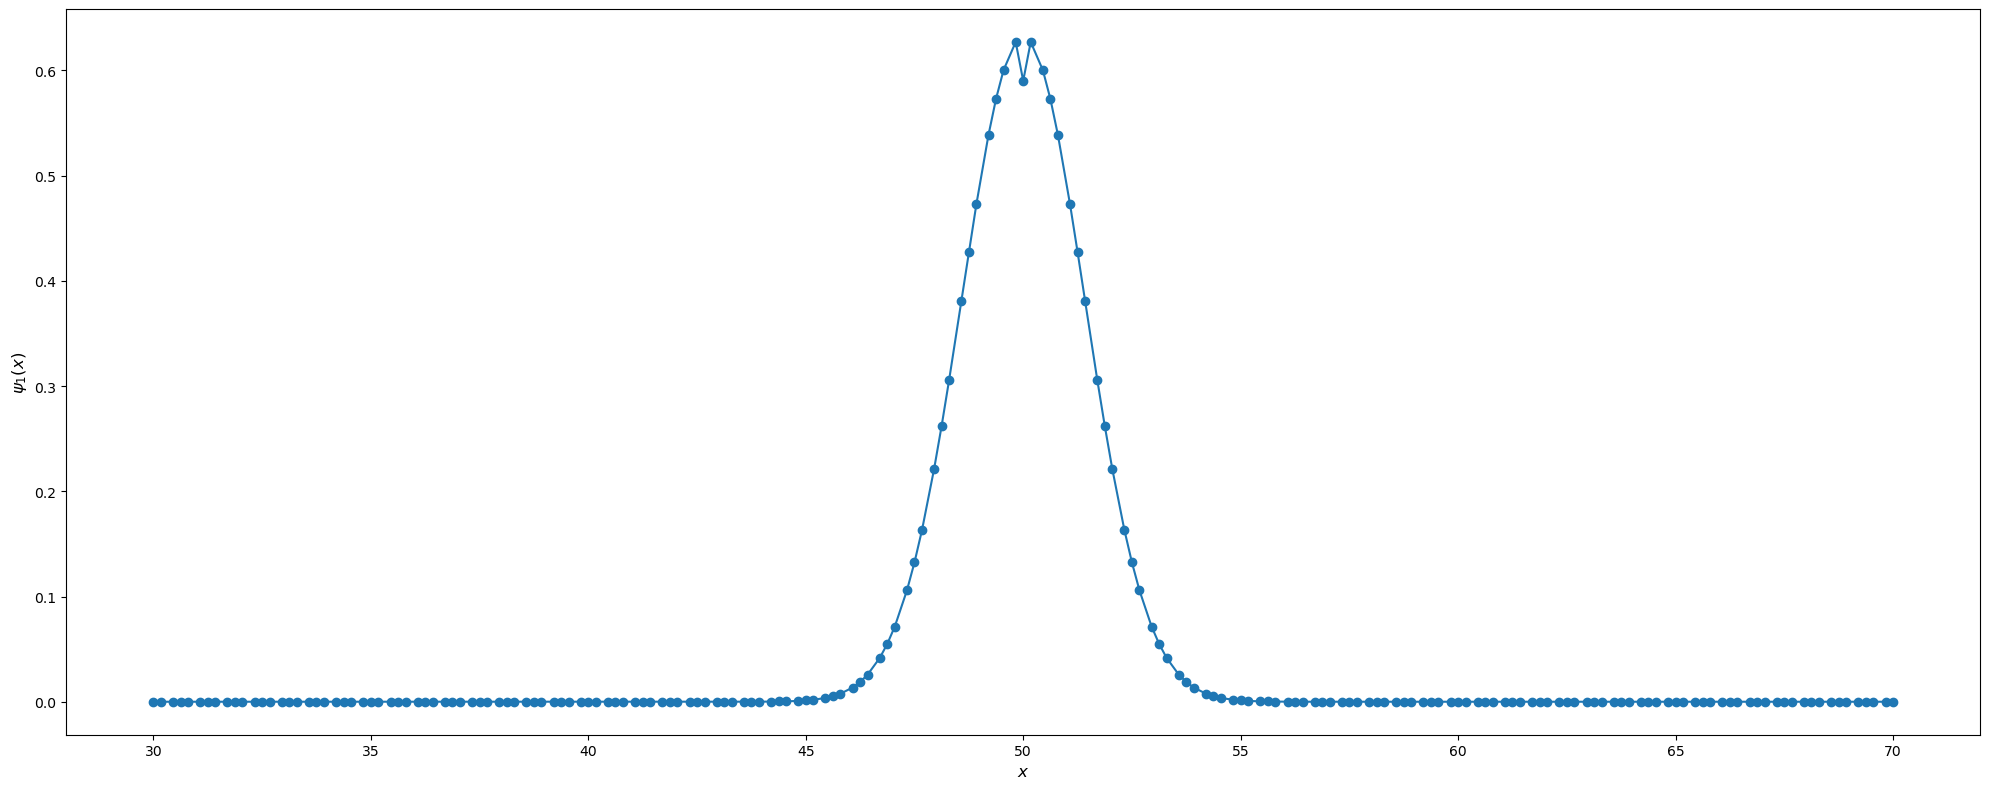

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

ax.plot(xref, psi_1, "-o")
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)

plt.tight_layout()

plt.tight_layout()
plt.show()

### Additional Part 2: Observing Index for the normal case

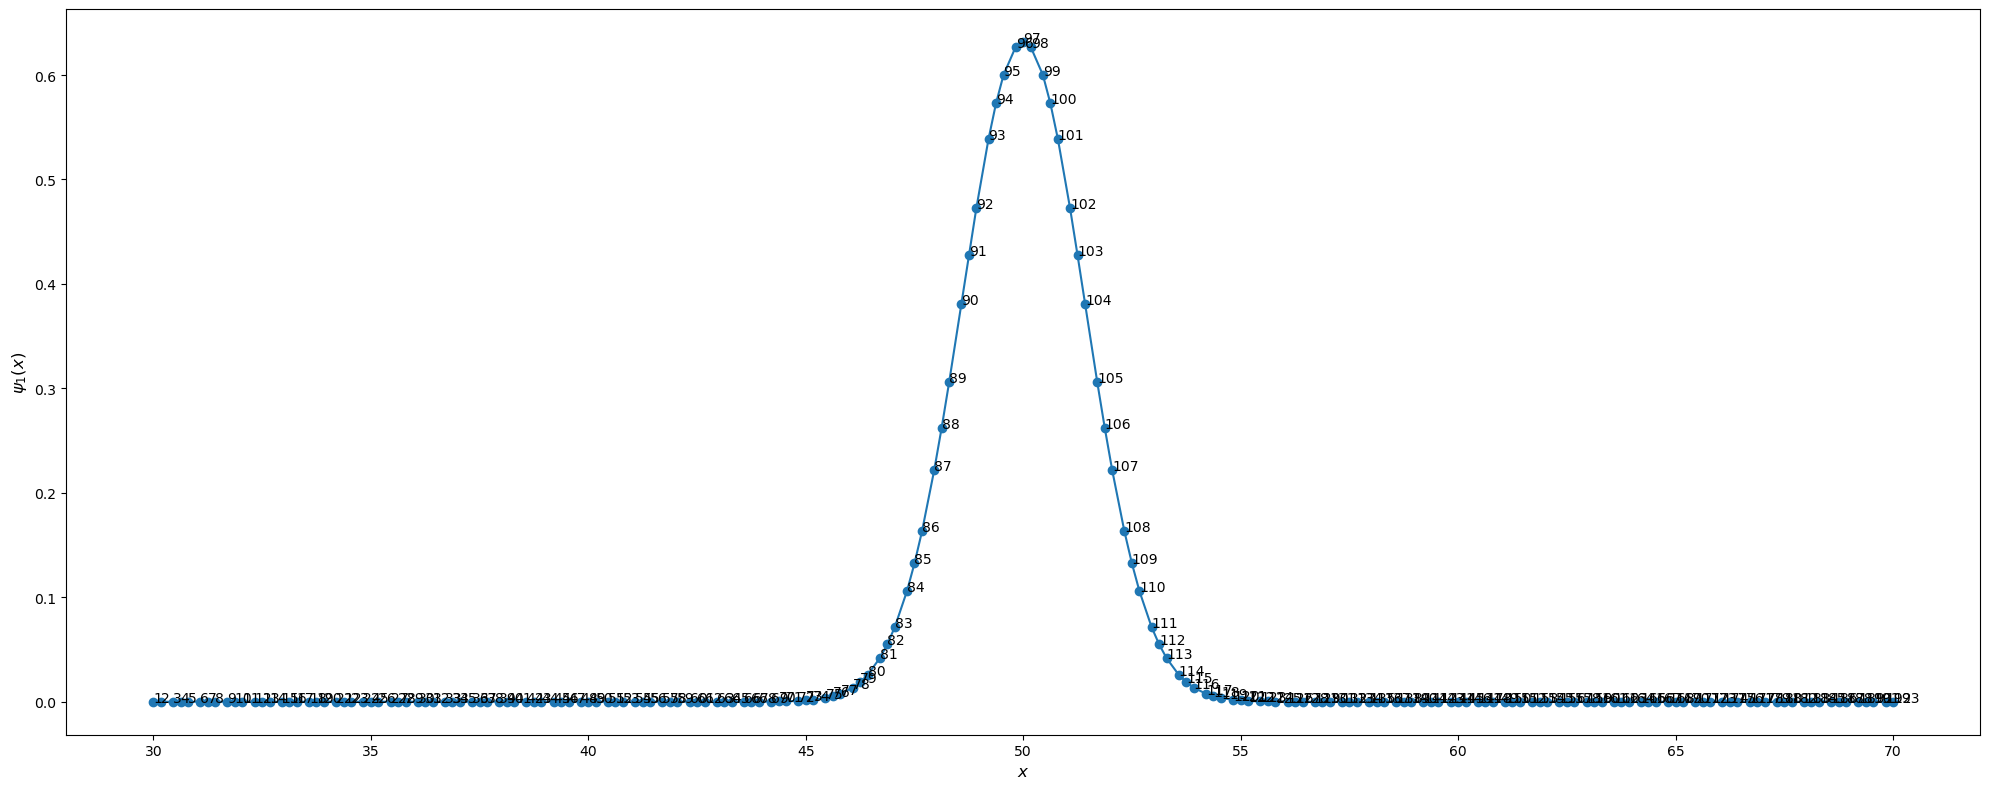

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

ax.plot(xref, psi_1, "-o")
ax.set_ylabel("\$ \\psi_1(x) \$", fontsize=12)
ax.set_xlabel("\$ x \$", fontsize=12)

for idx = 1:N
    xvalue = xref[idx]
    yvalue = psi_1[idx]
    ax.text(xvalue, yvalue, idx)
end

plt.tight_layout()

plt.tight_layout()
plt.show()